**glob** module -  to search for files that match a specific file pattern or name

## Classifying names with a character level RNN

In [2]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [4]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
import torch

all_letters=string.ascii_letters + string.punctuation #character set
n_letters=len(all_letters)

def letter2idx(letter):
    return all_letters.find(letter)

def letter2tensor(letter):
    tensor=torch.zeros(size=(1,n_letters))
    tensor[0][letter2idx(letter)]=1
    return tensor

def line2tensor(line):
    line_length=len(line)
    tensor=torch.zeros(size=(line_length,1,n_letters))

    for li,letter in enumerate(line):
        tensor[li][0][letter2idx(letter)]=1
    
    return tensor

print(letter2tensor('K'))
print(line2tensor('Kevin').shape)


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([5, 1, 84])


In [6]:
import torch.nn as nn
import torch.nn.functional as F
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size=hidden_size
        self.i2h=nn.Linear(in_features=input_size,out_features=hidden_size)
        self.h2h=nn.Linear(in_features=hidden_size,out_features=hidden_size)
        self.h2o=nn.Linear(in_features=hidden_size,out_features=output_size)

        self.softmax=nn.LogSoftmax(dim=1)
    
    def forward(self,input,hidden):
        #input being passed one by one
        # 1,n_features
        hidden=F.tanh(self.i2h(input) + self.h2h(hidden))
        output=self.softmax(self.h2o(hidden))
        return output,hidden
    def initHidden(self):
        h0=torch.zeros(1,self.hidden_size)
        return h0

n_hidden=128
rnn=RNN(n_letters,n_hidden,n_categories)




In [7]:
input = letter2tensor('K')
hidden=torch.zeros(1,n_hidden)

output,next_hidden=rnn(input,hidden)

In [8]:
input=line2tensor('Kevin')
hidden=torch.zeros(1,n_hidden)

output,next_hidden=rnn(input[0],hidden)
print(output)

tensor([[-2.8942, -2.8655, -2.8164, -2.9505, -2.8741, -3.0231, -2.8281, -2.8160,
         -2.9266, -2.9943, -2.8863, -2.8227, -2.9360, -2.9450, -2.8729, -2.7850,
         -2.8776, -2.9491]], grad_fn=<LogSoftmaxBackward0>)


In [9]:
def categoryfromoutput(output):
    top_n,top_i=output.topk(1)
    category_i=top_i[0].item()
    return all_categories[category_i],category_i

print(categoryfromoutput(output))



('Dutch', 15)


In [10]:
import random
def randomChoice(l):
    idx=random.randint(0,len(l)-1)
    return l[idx]

def randomTrainingexample():
    category=randomChoice(all_categories)
    line=randomChoice(category_lines[category])

    category_tensor=torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor=line2tensor(line)
    return category,line,category_tensor,line_tensor


for i in range(20):
    category,line,category_tensor,line_tensor=randomTrainingexample()
    print('category=',category,'| line=',line)

    


category= German | line= Schirmer
category= Czech | line= Naizer
category= Dutch | line= Snaijer
category= Czech | line= Metjeka
category= Italian | line= Ongaro
category= Scottish | line= Hay
category= Scottish | line= Mackenzie
category= Czech | line= Wizner
category= Portuguese | line= Machado
category= Spanish | line= Vargas
category= Italian | line= Traversa
category= Polish | line= Koziol
category= Polish | line= Sokoloff
category= French | line= Lestrange
category= Arabic | line= Sleiman
category= Japanese | line= Motoyoshi
category= Japanese | line= Arita
category= Czech | line= Svejda
category= Korean | line= Byon
category= Greek | line= Milionis


In [11]:
print(line_tensor[0])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [12]:
criterion=nn.NLLLoss()

learning_rate=0.005

def train(category_tensor,line_tensor):
    hidden=rnn.initHidden()

    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output,hidden=rnn(line_tensor[i],hidden)

    loss=criterion(output,category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha=-learning_rate)
    return output, loss.item()

In [13]:

import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingexample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    
    if iter % print_every == 0:
        guess, guess_i = categoryfromoutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.7098 Rocha / Japanese ✗ (Spanish)
10000 10% (0m 10s) 1.6229 Duong / Vietnamese ✓
15000 15% (0m 15s) 1.2725 Cardozo / Portuguese ✓
20000 20% (0m 20s) 2.2909 Koumans / English ✗ (Dutch)
25000 25% (0m 26s) 1.0068 Miyoshi / Arabic ✗ (Japanese)
30000 30% (0m 31s) 0.9352 Ho / Vietnamese ✓
35000 35% (0m 37s) 2.0975 Nifterick / Polish ✗ (Dutch)
40000 40% (0m 42s) 0.9469 Machacek / Czech ✓
45000 45% (0m 48s) 0.2886 Mai / Chinese ✓
50000 50% (0m 53s) 0.0851 Alberighi / Italian ✓
55000 55% (0m 59s) 2.9655 Morales / Greek ✗ (Spanish)
60000 60% (1m 4s) 1.5541 Kaluza / Arabic ✗ (Polish)
65000 65% (1m 10s) 0.0966 Patselas / Greek ✓
70000 70% (1m 15s) 0.4723 Yan / Chinese ✓
75000 75% (1m 21s) 0.0572 Pefanis / Greek ✓
80000 80% (1m 26s) 1.4322 Martin / Irish ✗ (Scottish)
85000 85% (1m 32s) 0.1965 Adamczak / Polish ✓
90000 90% (1m 37s) 0.2480 Lindsay / Scottish ✓
95000 95% (1m 42s) 1.0036 Thorley / English ✓
100000 100% (1m 47s) 0.1281 Sinclair / Scottish ✓


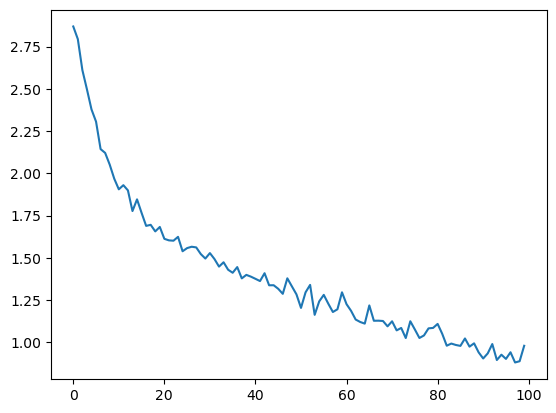

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/var/folders/7j/6p_pd3gd44zfw3nn6n10_pnh0000gn/T/ipykernel_2157/2800986656.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/7j/6p_pd3gd44zfw3nn6n10_pnh0000gn/T/ipykernel_2157/2800986656.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


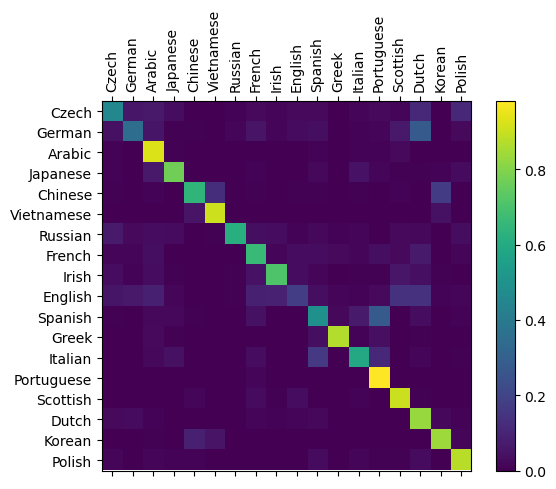

In [17]:
## Evaluating the results


confusion=torch.zeros(n_categories,n_categories)
n_confusion=10000

def evaluate(line_tensor):
    hidden=rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output,hidden=rnn(line_tensor[i],hidden)
    
    return output


for i in range(n_confusion):
    category,line,category_tensor,line_tensor=randomTrainingexample()
    output=evaluate(line_tensor)

    guess,guess_i=categoryfromoutput(output)
    category_i=all_categories.index(category)

    confusion[category_i][guess_i]+=1


for i in range(n_categories):
    confusion[i]=confusion[i] / confusion[i].sum()

fig, ax = plt.subplots()  # fig and ax are created here

# Display the confusion matrix
cax = ax.matshow(confusion.numpy(), cmap='viridis')  # Add cmap for color scheme
fig.colorbar(cax)  # Add color bar

# Set labels
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Set major tick locations
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

plt.show()